In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [216]:
#data folder path definition
data_path='c:\\Users\\seyma\\personal_work\\sanofi\\Sanofi_Challenge\\Data\\'

In [217]:
#first load the excel document
Excel_file=pd.ExcelFile(data_path+"Datainput.xlsx")

#create data frames for each sheet in the excel file
Combined_Yields=pd.read_excel(Excel_file,sheet_name="Combined_Yields")
QC_Data=pd.read_excel(Excel_file,sheet_name="QC_Data")
IoT=pd.read_excel(Excel_file,sheet_name="IoT")
Campaign_Info=pd.read_excel(Excel_file,sheet_name="Campaign_Info")
Batch_Genealogy=pd.read_excel(Excel_file,sheet_name="Batch_Genealogy")

In the Doc, they have said *All metrics and raw data inputs are aggregated to the BATCH_ID+MATERIAL_ID level* So, I will combine those two column into one ID column. It refers a production unit in process.

In [218]:
# Merge the BATCH_ID and MATERIAL_ID columns into a new_id column in QC_Data
QC_Data['new_id'] = QC_Data['BATCH_ID'].astype(str) + QC_Data['MATERIAL_ID']

# Merge the BATCH_ID and MATERIAL_ID columns into a new_id column in Combined_Yields_full
Combined_Yields['new_id'] = Combined_Yields['BATCH_ID'].astype(str) + Combined_Yields['MATERIAL_ID']

# Merge the BATCH_ID and MATERIAL_ID columns into a new_id column in Batch_Genealogy
Batch_Genealogy['new_id'] = Batch_Genealogy['BATCH_ID'].astype(str) + Batch_Genealogy['MATERIAL_ID']

# Merge the BATCH_ID and MATERIAL_ID columns into a new_id column in Campaign_Info
Campaign_Info.dropna(subset=['BATCH_ID'], inplace=True)
Campaign_Info['BATCH_ID'] = Campaign_Info['BATCH_ID'].astype(int)
Campaign_Info['new_id'] = Campaign_Info['BATCH_ID'].astype(str) + Campaign_Info['MATERIAL_ID']

# Merge the BATCH_ID and MATERIAL_ID columns into a new_id column in IoT
IoT.dropna(subset=['BATCH_ID'], inplace=True)
IoT['BATCH_ID'] = IoT['BATCH_ID'].astype(int)

IoT['new_id'] = IoT['BATCH_ID'].astype(str) + IoT['MATERIAL_ID']


In the Document, they said *"You can use the “activity_coefficient” (column YIELD_NAME) of these output batches as the target in your model"*


So, Let's begin with filtering materials who has YIELD_NAME equal to “activity_coefficient”

In [219]:
Combined_Yields[Combined_Yields.YIELD_NAME=="activity_coefficient"]

,BATCH_ID,MATERIAL_ID,MANUFACTURE_DATE,STAGE,YIELD_NAME,YIELD_VALUE,new_id
0,120932,P10446,20200612,s2,activity_coefficient,1.335753,120932P10446
1,120928,P10444,20200924,s2,activity_coefficient,1.275753,120928P10444
2,120935,P10444,20201015,s2,activity_coefficient,1.299432,120935P10444
3,120928,P10446,20200511,s2,activity_coefficient,1.324042,120928P10446
4,119136,P10344,20190329,s2,activity_coefficient,1.332979,119136P10344
...,...,...,...,...,...,...,...
168,122826,P10449,20221006,s2,activity_coefficient,1.124211,122826P10449
169,122810,P10148,20220831,s2,activity_coefficient,NaN,122810P10148
170,122828,P10449,20221028,s2,activity_coefficient,1.105905,122828P10449
171,122829,P10449,20221117,s2,activity_coefficient,1.134234,122829P10449


We have 173 data points but 65 of them have missing value on target variable.

In [220]:
Combined_Yields[Combined_Yields.YIELD_NAME=="activity_coefficient"].isna().sum()

BATCH_ID             0
MATERIAL_ID          0
MANUFACTURE_DATE     0
STAGE                0
YIELD_NAME           0
YIELD_VALUE         65
new_id               0
dtype: int64

I have decided to dropping those missing values. However, there may some ways to fill them but it is time consuming.

In [221]:
Combined_Yields_full=Combined_Yields[Combined_Yields.YIELD_NAME=="activity_coefficient"].dropna()

In [222]:
Combined_Yields_full.isna().sum()

BATCH_ID            0
MATERIAL_ID         0
MANUFACTURE_DATE    0
STAGE               0
YIELD_NAME          0
YIELD_VALUE         0
new_id              0
dtype: int64

In [223]:
#Transforming type from string to DateTime
Combined_Yields_full['MANUFACTURE_DATE'] = pd.to_datetime(Combined_Yields_full['MANUFACTURE_DATE'], format='%Y%m%d')

#for better understanding, Sorting values in ASC order
Combined_Yields_full = Combined_Yields_full.sort_values('MANUFACTURE_DATE')

I will drop STAGE and YIELD_NAME columns because they are consisting only one value. They are not differenciating.

In [224]:
Combined_Yields_full=Combined_Yields_full.drop(['STAGE','YIELD_NAME'], axis=1)

In [225]:
unique_combinations = Combined_Yields_full[['BATCH_ID', 'MATERIAL_ID','new_id','MANUFACTURE_DATE']].nunique()
print("# of unique: ")
print(unique_combinations)

# of unique: 
BATCH_ID             82
MATERIAL_ID           9
new_id              108
MANUFACTURE_DATE    106
dtype: int64


In [226]:
Combined_Yields_full

,BATCH_ID,MATERIAL_ID,MANUFACTURE_DATE,YIELD_VALUE,new_id
19,116785,P10344,2018-02-28,1.403015,116785P10344
20,116786,P10344,2018-03-23,1.368750,116786P10344
18,116787,P10344,2018-04-16,1.293267,116787P10344
24,116788,P10344,2018-06-14,1.326514,116788P10344
4,119136,P10344,2019-03-29,1.332979,119136P10344
...,...,...,...,...,...
153,122816,P10444,2022-12-01,1.522965,122816P10444
152,122818,P10444,2022-12-08,1.495911,122818P10444
158,122820,P10444,2022-12-15,1.496574,122820P10444
115,122821,P10444,2022-12-22,1.490813,122821P10444


In [227]:
for i in Combined_Yields_full["new_id"].unique():
    len_i=str(len(Combined_Yields_full[Combined_Yields_full["new_id"]==i]))
    print("Material {} has {} Yield Value for training".format(i,len_i))
    print("----------------------------------------------")

Material 116785P10344 has 1 Yield Value for training
----------------------------------------------
Material 116786P10344 has 1 Yield Value for training
----------------------------------------------
Material 116787P10344 has 1 Yield Value for training
----------------------------------------------
Material 116788P10344 has 1 Yield Value for training
----------------------------------------------
Material 119136P10344 has 1 Yield Value for training
----------------------------------------------
Material 119142P10344 has 1 Yield Value for training
----------------------------------------------
Material 119144P10344 has 1 Yield Value for training
----------------------------------------------
Material 119146P10344 has 1 Yield Value for training
----------------------------------------------
Material 120933P10349 has 1 Yield Value for training
----------------------------------------------
Material 120942P10346 has 1 Yield Value for training
----------------------------------------------


In [228]:
Combined_Yields_full

,BATCH_ID,MATERIAL_ID,MANUFACTURE_DATE,YIELD_VALUE,new_id
19,116785,P10344,2018-02-28,1.403015,116785P10344
20,116786,P10344,2018-03-23,1.368750,116786P10344
18,116787,P10344,2018-04-16,1.293267,116787P10344
24,116788,P10344,2018-06-14,1.326514,116788P10344
4,119136,P10344,2019-03-29,1.332979,119136P10344
...,...,...,...,...,...
153,122816,P10444,2022-12-01,1.522965,122816P10444
152,122818,P10444,2022-12-08,1.495911,122818P10444
158,122820,P10444,2022-12-15,1.496574,122820P10444
115,122821,P10444,2022-12-22,1.490813,122821P10444


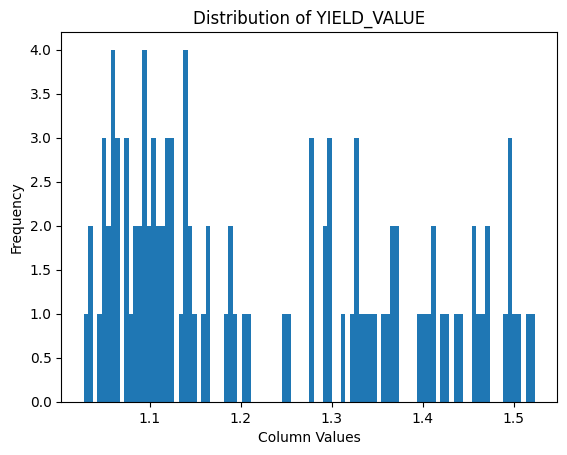

In [229]:
column_data = Combined_Yields_full['YIELD_VALUE']

# Plot a histogram to visualize the distribution
plt.hist(column_data, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Column Values')
plt.ylabel('Frequency')
plt.title('Distribution of YIELD_VALUE')
plt.show()


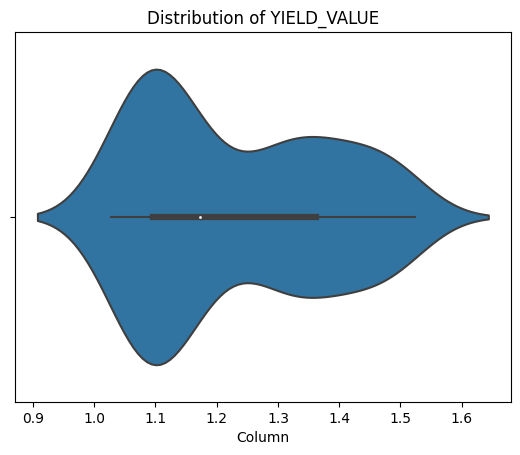

In [230]:
sns.violinplot(x=column_data)
plt.xlabel('Column')
plt.title('Distribution of YIELD_VALUE')
plt.show()

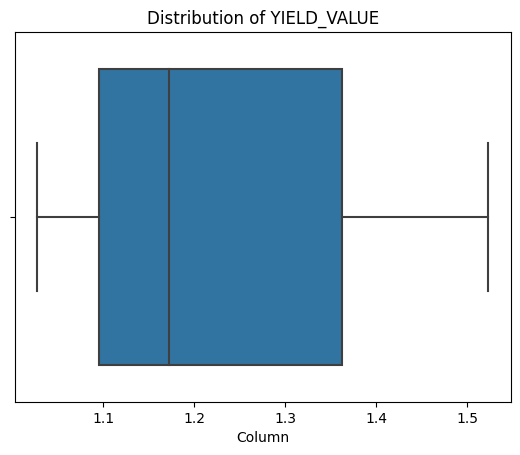

In [231]:
sns.boxplot(x=column_data)
plt.xlabel('Column')
plt.title('Distribution of YIELD_VALUE')
plt.show()

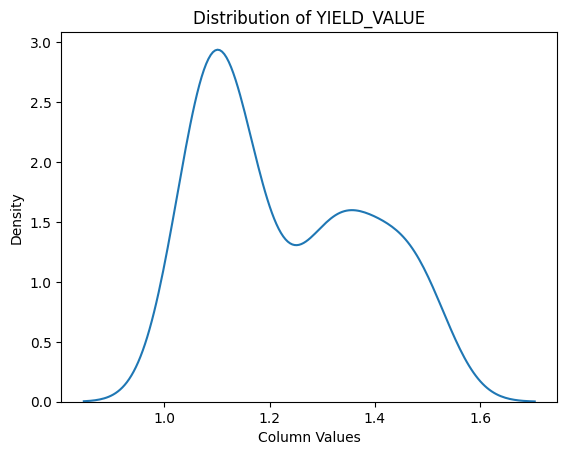

In [232]:
sns.kdeplot(column_data)
plt.xlabel('Column Values')
plt.ylabel('Density')
plt.title('Distribution of YIELD_VALUE')
plt.show()

Campain Info table has only ID so, it will not add anything

In [233]:
Campaign_Info

,BATCH_ID,MATERIAL_ID,CAMPAIGN_ID,BATCH_POSITION,new_id
0,119114,P10343,12.0,1.0,119114P10343
1,122803,P10450,62.0,1.0,122803P10450
2,121831,P10449,37.0,1.0,121831P10449
3,121832,P10449,37.0,2.0,121832P10449
4,122828,P10449,63.0,1.0,122828P10449
...,...,...,...,...,...
152,122817,P10449,48.0,2.0,122817P10449
153,119133,P10344,3.0,1.0,119133P10344
154,119134,P10344,3.0,2.0,119134P10344
155,119135,P10344,3.0,3.0,119135P10344


So, we have IoT sheet, I need to join this table as well. It will be same join on material and batch ids

In [234]:
IoT

,MATERIAL_ID,campagne finance,BATCH_ID,1_con_dur,1_con_temp,1_fil_dur,1_final PH,2_alka_hydro_dur,2_fil_dur,2_final_PH,...,3_2_temp of hep solution,3_2_vol precipitate,3_2_vol_red supernatant_UOL,stage_3_1b_nacl cont,3_2_vol reactor,3_2a_vol reactor,3_2b_vol reactor,fet_3_1a_final PH,fet_3_1a_initial PH,new_id
0,P10444,38,121840,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,80.0,0.133333,NaN,2979.0,NaN,2979.0,NaN,NaN,121840P10444
1,P10444,42,120940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120940P10444
4,P10449,58,122824,78.0,79.0,459.0,9.1,370.0,93.0,11.1,...,19.0,215.0,0.100000,0.1006,5955.0,2974.0,2981.0,5.3,5.5,122824P10449
5,P10450,62,122803,78.0,79.0,468.0,9.1,372.0,98.0,11.1,...,19.0,195.0,0.066667,0.1000,5975.0,2981.0,2994.0,5.3,5.4,122803P10450
6,P10449,58,122825,89.0,77.0,473.0,9.1,371.0,85.0,11.1,...,19.0,192.5,0.060000,0.0996,5968.0,2976.0,2992.0,5.3,5.4,122825P10449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,P10449,43,121839,77.0,80.0,838.0,9.1,372.0,142.0,11.1,...,19.0,190.0,0.066667,0.0998,5966.0,2976.0,2990.0,5.3,5.4,121839P10449
97,P10449,34,121827,78.0,79.0,843.0,9.1,371.0,123.0,11.0,...,20.0,175.0,0.056667,0.0996,5960.0,2970.0,2990.0,5.3,5.5,121827P10449
98,P10444,30,120934,83.0,79.0,878.0,9.1,380.0,118.0,11.1,...,19.0,140.0,0.050000,0.1033,5972.0,2977.0,2995.0,5.3,5.4,120934P10444
99,P10449,61,122827,77.0,79.0,1074.0,9.1,379.0,110.0,11.1,...,19.0,180.0,0.100000,0.1053,5976.0,2982.0,2994.0,5.3,5.4,122827P10449


In [235]:
column_na_counts = IoT.isna().sum()

# Iterate over the column_na_counts Series and print each column along with its corresponding NaN count
for column, count in column_na_counts.items():
    print(f"{column}: {count}")

MATERIAL_ID: 0
campagne finance: 0
BATCH_ID: 0
1_con_dur: 2
1_con_temp: 2
1_fil_dur: 2
1_final PH: 2
2_alka_hydro_dur: 2
2_fil_dur: 2
2_final_PH: 2
3_1a_etoh rto: 2
3_1a_etoh temp: 2
3_1a_hep concent: 2
3_1a_nacl cont: 2
3_1a_settl_dur: 2
3_2a_initial PH: 2
3_2a_etoh rto: 2
3_2a_hep cont: 2
3_2a_nacl cont: 2
3_2b_settl_dur: 1
3_2a_etoh temp: 2
3_2a_temp of hep solution: 2
4_dry extr_lod: 1
4_fil_dur: 1
4_Total vol: 1
4-2_etoh_rto: 1
4-3 etoh cont_Mother_liquor: 1
4-3_etoh cont: 1
stage5_drying_dur: 2
anti_iia_sur_sec: 0
3_2b_vol_red supernatant_UOL: 1
3_2b_vol precipitate: 1
3_2b_temp of hep solution: 1
3_2b_PH_before feeding: 1
3_2b_PH after feeding: 1
3_2b_hep concent: 1
3_2b_etoh_temp: 1
3_2b_etoh_rto: 1
3_2a_vol red_supernatant_UOL: 2
3_2a_vol precipitate: 2
3_2a_total vol after settl: 2
3_2a_settl_dur: 2
3_2a_nacl cont_: 2
3_2a_final PH: 2
3_1b_vol red supernatant_UOL: 25
3_1b_vol precipitate: 25
3_1b_total vol: 14
3_1b_temp of hep solution: 2
3_1b_settl_dur: 2
3_1b_initial PH: 3


In [236]:
IoT.dropna(inplace=True)
IoT

,MATERIAL_ID,campagne finance,BATCH_ID,1_con_dur,1_con_temp,1_fil_dur,1_final PH,2_alka_hydro_dur,2_fil_dur,2_final_PH,...,3_2_temp of hep solution,3_2_vol precipitate,3_2_vol_red supernatant_UOL,stage_3_1b_nacl cont,3_2_vol reactor,3_2a_vol reactor,3_2b_vol reactor,fet_3_1a_final PH,fet_3_1a_initial PH,new_id
5,P10450,62,122803,78.0,79.0,468.0,9.1,372.0,98.0,11.1,...,19.0,195.0,0.066667,0.1000,5975.0,2981.0,2994.0,5.3,5.4,122803P10450
7,P10449,61,122826,78.0,77.0,474.0,9.1,383.0,113.0,11.1,...,19.0,190.0,0.066667,0.1006,5978.0,2981.0,2997.0,5.3,5.4,122826P10449
8,P10450,35,121818,78.0,79.0,477.0,9.1,395.0,310.0,11.1,...,20.0,175.0,0.066667,0.0989,5970.0,2976.0,2994.0,5.3,5.3,121818P10450
9,P10450,65,122804,78.0,80.0,490.0,9.1,373.0,96.0,11.1,...,19.0,185.0,0.100000,0.1013,5978.0,2981.0,2997.0,5.3,5.4,122804P10450
10,P10449,36,121828,76.0,79.0,494.0,9.1,371.0,138.0,11.1,...,20.0,190.0,0.066667,0.0991,5961.0,2969.0,2992.0,5.3,5.4,121828P10449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,P10449,37,121832,100.0,80.0,738.0,9.1,375.0,142.0,11.1,...,20.0,185.0,0.066667,0.0983,5971.0,2974.0,2997.0,5.3,5.3,121832P10449
93,P10444,40,121844,77.0,79.0,743.0,9.1,380.0,119.0,11.1,...,21.0,155.0,0.066667,0.0989,5985.0,2993.0,2992.0,5.3,5.5,121844P10444
94,P10449,36,121829,113.0,79.0,816.0,9.1,371.0,154.0,11.1,...,20.0,190.0,0.066667,0.1003,5969.0,2974.0,2995.0,5.3,5.4,121829P10449
96,P10449,43,121839,77.0,80.0,838.0,9.1,372.0,142.0,11.1,...,19.0,190.0,0.066667,0.0998,5966.0,2976.0,2990.0,5.3,5.4,121839P10449


In [237]:
merged_df = pd.merge(Combined_Yields_full, IoT, on=['BATCH_ID', 'MATERIAL_ID'])

In [238]:
merged_df

,BATCH_ID,MATERIAL_ID,MANUFACTURE_DATE,YIELD_VALUE,new_id_x,campagne finance,1_con_dur,1_con_temp,1_fil_dur,1_final PH,...,3_2_temp of hep solution,3_2_vol precipitate,3_2_vol_red supernatant_UOL,stage_3_1b_nacl cont,3_2_vol reactor,3_2a_vol reactor,3_2b_vol reactor,fet_3_1a_final PH,fet_3_1a_initial PH,new_id_y
0,120934,P10449,2020-07-21,1.056216,120934P10449,29,78.0,80.0,525.0,9.1,...,19.0,195.0,0.016667,0.1024,5955.0,2970.0,2985.0,5.3,5.4,120934P10449
1,120928,P10444,2020-09-24,1.275753,120928P10444,30,75.0,77.0,681.0,9.1,...,19.0,145.0,0.033333,0.0995,5972.0,2977.0,2995.0,5.3,5.4,120928P10444
2,120930,P10444,2020-10-01,1.395169,120930P10444,30,75.0,80.0,615.0,9.1,...,19.0,140.0,0.036667,0.1005,5968.0,2976.0,2992.0,5.3,5.5,120930P10444
3,120932,P10444,2020-10-08,1.408540,120932P10444,30,154.0,78.0,621.0,9.1,...,19.0,140.0,0.066667,0.1020,5974.0,2977.0,2997.0,5.3,5.5,120932P10444
4,120934,P10444,2020-10-12,1.346610,120934P10444,30,83.0,79.0,878.0,9.1,...,19.0,140.0,0.050000,0.1033,5972.0,2977.0,2995.0,5.3,5.4,120934P10444
5,120935,P10444,2020-10-15,1.299432,120935P10444,30,87.0,78.0,650.0,9.1,...,19.0,140.0,0.066667,0.0999,5964.0,2976.0,2988.0,5.3,5.4,120935P10444
6,120936,P10444,2020-10-16,1.325303,120936P10444,30,82.0,79.0,587.0,9.1,...,19.0,140.0,0.053333,0.0983,5966.0,2972.0,2994.0,5.3,5.4,120936P10444
7,120937,P10444,2020-10-23,1.312790,120937P10444,30,127.0,79.0,611.0,9.1,...,19.0,137.5,0.033333,0.1025,5962.0,2967.0,2995.0,5.3,5.3,120937P10444
8,120938,P10444,2020-10-27,1.373340,120938P10444,30,79.0,80.0,596.0,9.1,...,19.0,140.0,0.066667,0.1006,5962.0,2972.0,2990.0,5.3,5.4,120938P10444
9,120938,P10449,2020-11-16,1.121699,120938P10449,31,209.0,79.0,559.0,9.1,...,19.0,190.0,0.066667,0.1056,5968.0,2976.0,2992.0,5.3,5.5,120938P10449


In [239]:
Combined_Yields_full

,BATCH_ID,MATERIAL_ID,MANUFACTURE_DATE,YIELD_VALUE,new_id
19,116785,P10344,2018-02-28,1.403015,116785P10344
20,116786,P10344,2018-03-23,1.368750,116786P10344
18,116787,P10344,2018-04-16,1.293267,116787P10344
24,116788,P10344,2018-06-14,1.326514,116788P10344
4,119136,P10344,2019-03-29,1.332979,119136P10344
...,...,...,...,...,...
153,122816,P10444,2022-12-01,1.522965,122816P10444
152,122818,P10444,2022-12-08,1.495911,122818P10444
158,122820,P10444,2022-12-15,1.496574,122820P10444
115,122821,P10444,2022-12-22,1.490813,122821P10444


Combined_Yields_full has 108 rows, after merging, data is shrinked 60! At this step I am not gonna add IoT table

Amounth of data is important for me, So I don't wanna lost any rows

One more join left. It is QC_Data

In [240]:
QC_Data

,BATCH_ID,MATERIAL_ID,MANUFACTURE_DATE,NEW_QC_TEST,VALUE,new_id
0,122875,P10051,20220704,pere_pour_azo,1.8,122875P10051
1,115705,P10005,20170721,cend_sul(fourni),NaN,115705P10005
2,115703,P10144,20171031,lla_fourni,NaN,115703P10144
3,120932,P10010,20200318,PH,6.9,120932P10010
4,122882,P10051,20220829,xa_tel_fourni,NaN,122882P10051
...,...,...,...,...,...,...
428973,122750,P10147,20201214,sul_ntu(fourni),NaN,122750P10147
428974,116258,P10044,20170109,cend_c1_creuset2,NaN,116258P10044
428975,118367,P10044,20180730,azot(fourni),NaN,118367P10044
428976,117224,P90111,20181127,than_fourni,NaN,117224P90111


In [241]:
#there were some zeros on the "MANUFACTURE_DATE" column. So, replaced them with NaN
QC_Data['MANUFACTURE_DATE'] = QC_Data['MANUFACTURE_DATE'].replace(0, np.nan)

#Transforming type from string to DateTime
QC_Data['MANUFACTURE_DATE'] = pd.to_datetime(QC_Data['MANUFACTURE_DATE'], format='%Y%m%d')

#for better understanding, Sorting values in ASC order
QC_Data = QC_Data.sort_values('MANUFACTURE_DATE')

In [242]:
QC_Data.isna().sum()

BATCH_ID                 0
MATERIAL_ID              0
MANUFACTURE_DATE      4070
NEW_QC_TEST              0
VALUE               372968
new_id                   0
dtype: int64

Most of the test result is empty. So I want to see which test metrics have a value

In [243]:
QC_Data[QC_Data["VALUE"].isna()==False]

,BATCH_ID,MATERIAL_ID,MANUFACTURE_DATE,NEW_QC_TEST,VALUE,new_id
162442,115078,P10344,2014-05-02,PH,6.500000,115078P10344
65814,115078,P10344,2014-05-02,ratio_xa_lla(sec),0.995146,115078P10344
132530,115078,P10344,2014-05-02,lla_sec,207.870838,115078P10344
381411,115078,P10344,2014-05-02,absorbance,0.053000,115078P10344
116709,115078,P10344,2014-05-02,lla_tel,206.000000,115078P10344
...,...,...,...,...,...,...
424401,119113,P10003,NaT,PH,7.900000,119113P10003
425262,119113,P10003,NaT,lod,3.800000,119113P10003
425541,119124,P10003,NaT,perte,0.999600,119124P10003
425721,117496,P10005,NaT,coag_wet,175.000000,117496P10005


In [244]:
QC_Data["NEW_QC_TEST"].nunique()

74

In [245]:
print("List of QC Tests that have value:")
print(QC_Data[QC_Data["VALUE"].isna()==False]["NEW_QC_TEST"].unique())
print("----------------------------------------------------------------")
print("Length of list:")
print(len(QC_Data[QC_Data["VALUE"].isna()==False]["NEW_QC_TEST"].unique()))

List of QC Tests that have value:
['PH' 'ratio_xa_lla(sec)' 'lla_sec' 'absorbance' 'lla_tel' 'xa_dry'
 'sul_ntu' 'xa_tel' 'lod' 'adn' 'coag_wet' 'coag_dry' 'anticoagulante '
 'masse' 'moyenne' 'ratio_80_24' 'teneur_eau' 'proteiniq' 'azot_sec'
 'otdlq_260' 'cend_sul' 'ethan' 'rende_la' 'otidiq' 'cal_sec' 'lines_sec'
 'otidiq_hplc' 'sod_sec' 'rende_uimg' 'perte' 'pertem2' 'pertem1'
 'robie_to' 'es2_perte' 'perem1cru1' 'perte_cre2' 'dessic_creuset'
 'dessic_moyenne' 'pertem1cru2' 'pertem2_cre1' 'pertem2_cre2' 'perte_cre1'
 'thanol' 'teneur_chon' 'butan' 'inque_lowry' 'pere_pour_lla'
 'cend_sul_creuset1' 'pere_pour_azo' 'es1_azo_sur_sec_pct'
 'cend_m_creuset1' 'es1_azo_sur_tel' 'cend_c2_creuset2' 'cend_sul_moy'
 'es2_azo_sur_tel' 'cend_sul_creuset2' 'cend_m_creuset2'
 'es2_azo_sur_sec_pct' 'cend_c2_creuset1' 'cend_c1_creuset2'
 'cend_c1_creuset1' 'ratio_xa_llafourni' 'than_fourni' 'xa_tel_fourni'
 'lla_fourni' 'xa_sec_fourni' 'lla_tel_fourni' 'enzym' 'azot(fourni)'
 'ratio_xa_lla(fourni)' 

In [246]:
print(QC_Data["MANUFACTURE_DATE"].max())
print(QC_Data["MANUFACTURE_DATE"].min())

2023-01-16 00:00:00
2014-05-02 00:00:00


In [247]:
unique_combinations = QC_Data[['BATCH_ID', 'MATERIAL_ID','NEW_QC_TEST','MANUFACTURE_DATE']].nunique()
print("# of unique: ")
print(unique_combinations)

# of unique: 
BATCH_ID            5181
MATERIAL_ID           40
NEW_QC_TEST           74
MANUFACTURE_DATE    1223
dtype: int64


In [248]:
#this is for understanding how many different pairs we have
unique_pairs_count = QC_Data[['BATCH_ID', 'MATERIAL_ID']].drop_duplicates().shape[0]
print(unique_pairs_count)


5797


In [249]:
QC_Data[['BATCH_ID', 'MATERIAL_ID']].drop_duplicates()

,BATCH_ID,MATERIAL_ID
79069,115078,P10344
57819,115079,P10344
65471,115081,P10011
109749,115126,P10004
378924,115125,P10004
...,...,...
16585,118915,P10006
16957,119736,P10005
19754,115779,P10005
20025,115775,P10005


In [250]:
#lets check the values in the QC data frame. are parent materials filled only or not?
output_materials=Combined_Yields_full["MATERIAL_ID"].unique() #9 materials
QC_materials_with_value=QC_Data[QC_Data["VALUE"].isna()==False]["MATERIAL_ID"].unique() #40 materails
common_ids = set(QC_materials_with_value).intersection(set(output_materials))
print(common_ids)
print("Length of intersection: {}".format(len(common_ids)))

{'P10450', 'P10346', 'P10444', 'P10349', 'P10446', 'P10344', 'P10350', 'P10443', 'P10449'}
Length of intersection: 9


So, our output materials have a QC test value. Also, our parent materials have.

In [251]:
#lets check the values in the QC data frame. are parent materials filled only or not?
output_materials=Combined_Yields_full["new_id"].unique() #108 materials
QC_materials_with_value=QC_Data[QC_Data["VALUE"].isna()==False]["new_id"].unique() #5797 materails
common_ids = set(QC_materials_with_value).intersection(set(output_materials))
print(common_ids)
print("Length of intersection: {}".format(len(common_ids)))

{'116786P10344', '120941P10444', '121838P10444', '119136P10344', '122817P10449', '120933P10350', '122788P10443', '120944P10444', '121829P10449', '122796P10450', '122802P10450', '120932P10446', '121844P10449', '122814P10449', '120935P10444', '121837P10449', '120936P10449', '120938P10449', '116785P10344', '122803P10450', '120930P10446', '121818P10450', '121836P10444', '120936P10444', '122800P10450', '120933P10349', '121841P10444', '121834P10449', '123711P10444', '121824P10450', '121834P10444', '121842P10449', '122822P10449', '120938P10444', '120943P10346', '122827P10449', '121832P10444', '119144P10344', '116788P10344', '121840P10444', '120934P10446', '122825P10449', '119146P10344', '121831P10444', '120935P10449', '122814P10444', '122812P10444', '121842P10444', '122821P10444', '121830P10449', '120934P10449', '120932P10444', '120937P10449', '122787P10443', '121826P10449', '120937P10444', '122798P10450', '120930P10444', '121832P10449', '121843P10444', '121814P10450', '121822P10450', '122799

Batch Genealogy

In [252]:
Batch_Genealogy

,BATCH_ID,MATERIAL_ID,LEVEL,TREE_ID,PROCESS_ORDER_NUMBER,MANUFACTURE_DATE,QUANTITY,UNIT_OF_MEASURE,MOVEMENT_TYPE,NEW_MATERIAL_DESCRIPTION,new_id
0,122812,P10449,2,02d31e7f93f5de3cb5b7fcc8ab00426f4f57f7fa33dad5...,R104490026,20220203,232.100,KG,101,hep_so,122812P10449
1,122813,P10449,2,02d31e7f93f5de3cb5b7fcc8ab00426f4f57f7fa33dad5...,R104490027,20220211,253.550,KG,101,hep_so,122813P10449
2,122825,P10449,2,0347d96c7e652f3ac24b2bf917652763581f0dc1b62594...,R104490036,20220916,265.100,KG,101,hep_so,122825P10449
3,121843,P10449,2,035e3927189e6c90047992537b968bde33f46a3b1acb9d...,R104490023,20211105,223.900,KG,101,hep_so,121843P10449
4,121823,P10450,2,035e3927189e6c90047992537b968bde33f46a3b1acb9d...,R104500007,20211021,227.200,KG,101,hep_so,121823P10450
...,...,...,...,...,...,...,...,...,...,...,...
4192,121907,P10010,2,4f6560e1695aacd541ba25c5ee8bf7ba7b013176c04354...,R104500005,20210106,25.035,KG,261,hep_bru_dc,121907P10010
4193,121908,P10010,2,243b6ba66876069e071084a9ba262c682c42b37e615588...,R104500005,20210113,26.041,KG,261,hep_bru_dc,121908P10010
4194,121908,P10010,2,4f6560e1695aacd541ba25c5ee8bf7ba7b013176c04354...,R104500005,20210113,26.041,KG,261,hep_bru_dc,121908P10010
4195,121909,P10010,2,243b6ba66876069e071084a9ba262c682c42b37e615588...,R104500005,20210114,5.916,KG,261,hep_bru_dc,121909P10010


In [253]:
Batch_Genealogy["MOVEMENT_TYPE"].unique()

array([101, 531, 261], dtype=int64)

In [254]:
Batch_Genealogy["LEVEL"].unique()

array([2], dtype=int64)

We have 3 different types of movement. 531 can be disregarded according to document. Also, Level column is not necessary because it stores only one variable for each row.

In [255]:
# Delete rows where MOVEMENT_TYPE is equal to 531
Batch_Genealogy = Batch_Genealogy[Batch_Genealogy['MOVEMENT_TYPE'] != 531]

# Remove the LEVEL column
Batch_Genealogy = Batch_Genealogy.drop('LEVEL', axis=1)

In [256]:
Batch_Genealogy["MOVEMENT_TYPE"].unique()

array([101, 261], dtype=int64)

In [257]:
#there were some zeros on the "MANUFACTURE_DATE" column. So, replaced them with NaN
Batch_Genealogy['MANUFACTURE_DATE'] = Batch_Genealogy['MANUFACTURE_DATE'].replace(0, np.nan)

#Transforming type from string to DateTime
Batch_Genealogy['MANUFACTURE_DATE'] = pd.to_datetime(Batch_Genealogy['MANUFACTURE_DATE'], format='%Y%m%d')

#for better understanding, Sorting values in ASC order
Batch_Genealogy = Batch_Genealogy.sort_values('MANUFACTURE_DATE')

In [258]:
#this is for understanding how many different pairs we have
unique_pairs_count = Batch_Genealogy[['BATCH_ID', 'MATERIAL_ID']].drop_duplicates().shape[0]
print(unique_pairs_count)


983


In [259]:
output_new_id_list=Batch_Genealogy[Batch_Genealogy["MOVEMENT_TYPE"]==101]["new_id"].unique()
print(len(output_new_id_list))

97


To check all output units have YIELD_VALUE or not.

In [260]:
output_materials=Combined_Yields_full["new_id"].unique() #108 materials
common_ids = set(output_materials).intersection(set(output_new_id_list))
print(common_ids)
print("Length of intersection: {}".format(len(common_ids)))

{'120941P10444', '121838P10444', '122817P10449', '122788P10443', '120944P10444', '121829P10449', '122796P10450', '122802P10450', '120932P10446', '121844P10449', '122814P10449', '120935P10444', '121837P10449', '120936P10449', '120938P10449', '122803P10450', '120930P10446', '121818P10450', '121836P10444', '120936P10444', '122800P10450', '121841P10444', '121834P10449', '123711P10444', '121824P10450', '121834P10444', '121842P10449', '122822P10449', '120938P10444', '122827P10449', '121832P10444', '121840P10444', '120934P10446', '122825P10449', '121831P10444', '120935P10449', '122814P10444', '122812P10444', '121842P10444', '122821P10444', '121830P10449', '120934P10449', '120932P10444', '120937P10449', '122787P10443', '121826P10449', '120937P10444', '122798P10450', '120930P10444', '121832P10449', '121843P10444', '121814P10450', '121822P10450', '122799P10450', '122824P10449', '122828P10449', '120945P10444', '122818P10444', '122804P10450', '120932P10449', '122812P10449', '122815P10449', '121816

In [261]:
Batch_Genealogy.isna().sum()

BATCH_ID                     0
MATERIAL_ID                  0
TREE_ID                      0
PROCESS_ORDER_NUMBER         0
MANUFACTURE_DATE            38
QUANTITY                     0
UNIT_OF_MEASURE              0
MOVEMENT_TYPE                0
NEW_MATERIAL_DESCRIPTION     0
new_id                       0
dtype: int64

In [262]:
Batch_Genealogy

,BATCH_ID,MATERIAL_ID,TREE_ID,PROCESS_ORDER_NUMBER,MANUFACTURE_DATE,QUANTITY,UNIT_OF_MEASURE,MOVEMENT_TYPE,NEW_MATERIAL_DESCRIPTION,new_id
705,115685,P10004,810e9cc06b5b83951e947a08130027227bd7a69446bdaa...,R104440001,2017-02-09,0.900,KG,261,hep_bru_li,115685P10004
694,115685,P10004,6a3f7ab370155694595e55d5a9ffca42b864dae2faa26e...,R104440001,2017-02-09,0.900,KG,261,hep_bru_li,115685P10004
770,115693,P10004,810e9cc06b5b83951e947a08130027227bd7a69446bdaa...,R104440001,2017-05-22,0.850,KG,261,hep_bru_li,115693P10004
759,115693,P10004,6a3f7ab370155694595e55d5a9ffca42b864dae2faa26e...,R104440001,2017-05-22,0.850,KG,261,hep_bru_li,115693P10004
636,117268,P10004,810e9cc06b5b83951e947a08130027227bd7a69446bdaa...,R104440005,2018-04-04,0.900,KG,261,hep_bru_li,117268P10004
...,...,...,...,...,...,...,...,...,...,...
2830,121581,P10005,87a29ab221a65ffec959eb711ae30461322fe83d42e9fb...,R104490010,NaT,25.476,KG,261,hep_bru_ck,121581P10005
2863,121581,P10005,bd255421b1a6fae818c27cb5f5c9355b276eaaf9454b41...,R104490010,NaT,25.476,KG,261,hep_bru_ck,121581P10005
3854,112924,P20098,2e058cc192750ec5c430545d046041b4dcf7dcccc0d117...,R104490001,NaT,2.000,1,261,fil22,112924P20098
3876,112924,P20098,a0754ba875ba2443c3c091d2069be5e392a4708d0ace61...,R104490001,NaT,2.000,1,261,fil22,112924P20098


In [263]:
unique_combinations = Batch_Genealogy[['BATCH_ID', 'MATERIAL_ID','new_id','TREE_ID','PROCESS_ORDER_NUMBER','MANUFACTURE_DATE','MOVEMENT_TYPE']].nunique()
print("# of unique: ")
print(unique_combinations)

# of unique: 
BATCH_ID                931
MATERIAL_ID              20
new_id                  983
TREE_ID                 137
PROCESS_ORDER_NUMBER     97
MANUFACTURE_DATE        477
MOVEMENT_TYPE             2
dtype: int64


In [264]:
#output batches
output_batches=Batch_Genealogy[Batch_Genealogy["MOVEMENT_TYPE"]==101]
output_batches

,BATCH_ID,MATERIAL_ID,TREE_ID,PROCESS_ORDER_NUMBER,MANUFACTURE_DATE,QUANTITY,UNIT_OF_MEASURE,MOVEMENT_TYPE,NEW_MATERIAL_DESCRIPTION,new_id
38,120928,P10446,32165b2eddcfb26b0a0a1409bf0d1c3e5230c42fdd426f...,R104460001,2020-05-11,165.62,KG,101,hep_so,120928P10446
62,120928,P10446,4ea6a53354958e942d9b5f9b498b197a09490b79c4cfe2...,R104460001,2020-05-11,165.62,KG,101,hep_so,120928P10446
63,120930,P10446,4ea6a53354958e942d9b5f9b498b197a09490b79c4cfe2...,R104460002,2020-05-14,209.63,KG,101,hep_so,120930P10446
161,120930,P10446,be5eca36c7f1eb270223aa08a378e34d808cf25f7b7ce2...,R104460002,2020-05-14,209.63,KG,101,hep_so,120930P10446
79,120932,P10446,6a3f7ab370155694595e55d5a9ffca42b864dae2faa26e...,R104460003,2020-06-12,182.80,KG,101,hep_so,120932P10446
...,...,...,...,...,...,...,...,...,...,...
45,122820,P10444,385afbeede879098c49e04e818e057cb755ce5d27f0830...,R104440031,2022-12-15,187.60,KG,101,hep_so,122820P10444
113,122820,P10444,88c6170522dad51ef9fddbc564d3da83a7d484184981be...,R104440031,2022-12-15,187.60,KG,101,hep_so,122820P10444
92,122821,P10444,79338195ac21acb995cbd61803fd4d5045f892ac51f6c8...,R104440032,2022-12-22,205.55,KG,101,hep_so,122821P10444
46,122821,P10444,385afbeede879098c49e04e818e057cb755ce5d27f0830...,R104440032,2022-12-22,205.55,KG,101,hep_so,122821P10444


In [265]:
#parent batches
parent_batches=Batch_Genealogy[Batch_Genealogy["MOVEMENT_TYPE"]==261]
parent_batches

,BATCH_ID,MATERIAL_ID,TREE_ID,PROCESS_ORDER_NUMBER,MANUFACTURE_DATE,QUANTITY,UNIT_OF_MEASURE,MOVEMENT_TYPE,NEW_MATERIAL_DESCRIPTION,new_id
705,115685,P10004,810e9cc06b5b83951e947a08130027227bd7a69446bdaa...,R104440001,2017-02-09,0.900,KG,261,hep_bru_li,115685P10004
694,115685,P10004,6a3f7ab370155694595e55d5a9ffca42b864dae2faa26e...,R104440001,2017-02-09,0.900,KG,261,hep_bru_li,115685P10004
770,115693,P10004,810e9cc06b5b83951e947a08130027227bd7a69446bdaa...,R104440001,2017-05-22,0.850,KG,261,hep_bru_li,115693P10004
759,115693,P10004,6a3f7ab370155694595e55d5a9ffca42b864dae2faa26e...,R104440001,2017-05-22,0.850,KG,261,hep_bru_li,115693P10004
636,117268,P10004,810e9cc06b5b83951e947a08130027227bd7a69446bdaa...,R104440005,2018-04-04,0.900,KG,261,hep_bru_li,117268P10004
...,...,...,...,...,...,...,...,...,...,...
2830,121581,P10005,87a29ab221a65ffec959eb711ae30461322fe83d42e9fb...,R104490010,NaT,25.476,KG,261,hep_bru_ck,121581P10005
2863,121581,P10005,bd255421b1a6fae818c27cb5f5c9355b276eaaf9454b41...,R104490010,NaT,25.476,KG,261,hep_bru_ck,121581P10005
3854,112924,P20098,2e058cc192750ec5c430545d046041b4dcf7dcccc0d117...,R104490001,NaT,2.000,1,261,fil22,112924P20098
3876,112924,P20098,a0754ba875ba2443c3c091d2069be5e392a4708d0ace61...,R104490001,NaT,2.000,1,261,fil22,112924P20098


In [266]:
print("OUTPUT BATCHES")
print("-------------------------------")
unique_combinations = output_batches[['BATCH_ID', 'MATERIAL_ID','TREE_ID','PROCESS_ORDER_NUMBER','MANUFACTURE_DATE','MOVEMENT_TYPE']].nunique()
print("Length of df: {}".format(len(output_batches)))
print("# of unique: ")
print(unique_combinations)

OUTPUT BATCHES
-------------------------------
Length of df: 208
# of unique: 
BATCH_ID                 74
MATERIAL_ID               5
TREE_ID                 137
PROCESS_ORDER_NUMBER     97
MANUFACTURE_DATE         95
MOVEMENT_TYPE             1
dtype: int64


In [267]:
print("PARENT BATCHES")
print("-------------------------------")
unique_combinations = parent_batches[['BATCH_ID', 'MATERIAL_ID','TREE_ID','PROCESS_ORDER_NUMBER','MANUFACTURE_DATE','MOVEMENT_TYPE']].nunique()
print("Length of df: {}".format(len(parent_batches)))
print("# of unique: ")
print(unique_combinations)

PARENT BATCHES
-------------------------------
Length of df: 3781
# of unique: 
BATCH_ID                885
MATERIAL_ID              16
TREE_ID                 137
PROCESS_ORDER_NUMBER     97
MANUFACTURE_DATE        439
MOVEMENT_TYPE             1
dtype: int64


This is underlies the statement in the document: *iv.	Output batches, which have movement type "101"  in the Batch_Genealogy sheet, are the ones used in yield calculation – they should have the target yield numbers in sheet Combined_Yields*

In [268]:
common_ids = set(output_batches['BATCH_ID']).intersection(set(Combined_Yields_full['BATCH_ID']))
print(len(common_ids))

73


Here is a material id both in output and parent batches

In [269]:
common_ids = set(output_batches['MATERIAL_ID']).intersection(set(parent_batches['MATERIAL_ID']))
print(common_ids)

{'P10444'}


In [270]:
Batch_Genealogy[(Batch_Genealogy["MATERIAL_ID"]=="P10444")&(Batch_Genealogy["MOVEMENT_TYPE"]==261)]

,BATCH_ID,MATERIAL_ID,TREE_ID,PROCESS_ORDER_NUMBER,MANUFACTURE_DATE,QUANTITY,UNIT_OF_MEASURE,MOVEMENT_TYPE,NEW_MATERIAL_DESCRIPTION,new_id
211,120939,P10444,45ae0fa98b910d382ecc91f707eb2aca0237354dc0f2fc...,R104440009R,2020-12-14,178.55,KG,261,hep_so,120939P10444
210,120939,P10444,3e817432abfaad60476e1898ad30732a1f8cddf91aa90b...,R104440009R,2020-12-14,178.55,KG,261,hep_so,120939P10444


In [271]:
#one tree_id
Batch_Genealogy[(Batch_Genealogy["PROCESS_ORDER_NUMBER"]=="R104440013")]

,BATCH_ID,MATERIAL_ID,TREE_ID,PROCESS_ORDER_NUMBER,MANUFACTURE_DATE,QUANTITY,UNIT_OF_MEASURE,MOVEMENT_TYPE,NEW_MATERIAL_DESCRIPTION,new_id
282,113513,P20098,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-04-27,2.0,1,261,fil22,113513P20098
283,113526,P20097,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-05-05,4.0,1,261,fil45,113526P20097
293,113549,P20094,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-05-28,48.3,L,261,sod3n,113549P20094
339,113558,P20095,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-06-03,33.0,KG,261,eauoxy,113558P20095
414,113575,P20003,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-06-09,24.0,KG,261,potasi,113575P20003
484,113610,P20002,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-07-21,30.0,KG,261,clarcel28,113610P20002
682,121330,P10004,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-09-29,300.0,KG,261,hep_bru_li,121330P10004
547,113741,P20093,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-11-06,26.1,L,261,acide_chlor,113741P20093
613,113743,P20096,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2020-11-06,687.5,KG,261,chlor_cal,113743P20096
42,120944,P10444,3475b6baa9edcedb02f27388c4312b27040cafaac0eae2...,R104440013,2021-01-18,164.3,KG,101,hep_so,120944P10444


In [272]:
#three tree_ids
Batch_Genealogy[(Batch_Genealogy["PROCESS_ORDER_NUMBER"]=="R104500018")]

,BATCH_ID,MATERIAL_ID,TREE_ID,PROCESS_ORDER_NUMBER,MANUFACTURE_DATE,QUANTITY,UNIT_OF_MEASURE,MOVEMENT_TYPE,NEW_MATERIAL_DESCRIPTION,new_id
1673,114256,P20095,83de933a762cd4bac2c5d935dbb448d698bb24c65d4671...,R104500018,2021-07-12,32.89,KG,261,eauoxy,114256P20095
1647,114256,P20095,46e27ad1ede70dc2a2572418adfe770c448ed33bcf7831...,R104500018,2021-07-12,32.89,KG,261,eauoxy,114256P20095
1651,114256,P20095,4acc8753bf3001bb01758aa4f022c794a4c28f93240669...,R104500018,2021-07-12,32.89,KG,261,eauoxy,114256P20095
1770,114426,P20094,4acc8753bf3001bb01758aa4f022c794a4c28f93240669...,R104500018,2021-10-26,36.40,L,261,sod3n,114426P20094
1766,114426,P20094,46e27ad1ede70dc2a2572418adfe770c448ed33bcf7831...,R104500018,2021-10-26,36.40,L,261,sod3n,114426P20094
...,...,...,...,...,...,...,...,...,...,...
2694,115010,P20096,83de933a762cd4bac2c5d935dbb448d698bb24c65d4671...,R104500018,2022-10-13,312.60,KG,261,chlor_cal,115010P20096
2664,115010,P20096,46e27ad1ede70dc2a2572418adfe770c448ed33bcf7831...,R104500018,2022-10-13,312.60,KG,261,chlor_cal,115010P20096
52,122804,P10450,46e27ad1ede70dc2a2572418adfe770c448ed33bcf7831...,R104500018,2022-11-25,244.65,KG,101,hep_so,122804P10450
57,122804,P10450,4acc8753bf3001bb01758aa4f022c794a4c28f93240669...,R104500018,2022-11-25,244.65,KG,101,hep_so,122804P10450


In [273]:
len(Batch_Genealogy[(Batch_Genealogy["PROCESS_ORDER_NUMBER"]=="R104440005")]["MATERIAL_ID"].unique())

10

In [274]:
duplicate_tree_ids = Batch_Genealogy.groupby('PROCESS_ORDER_NUMBER')['TREE_ID'].unique()

print(duplicate_tree_ids)
#duplicate_tree_ids.to_excel("C:\\Users\\seyma\\Downloads\\output_2.xlsx")

PROCESS_ORDER_NUMBER
R104430001    [9d559718f52d5c6ea7e4ac97ee8d8a25403c5846337e2...
R104430002    [79338195ac21acb995cbd61803fd4d5045f892ac51f6c...
R104440001    [810e9cc06b5b83951e947a08130027227bd7a69446bda...
R104440002    [aa19de414ad4a0e5c2572c5b819e63c9570e0944a888b...
R104440003    [5c24eb0b93bd3471e61ce16bef973f4b5b8792d9a0658...
                                    ...                        
R104500014    [8cd8f874c0baaab9088b1d89b4cb919c5643a8e85ead2...
R104500015    [8cd8f874c0baaab9088b1d89b4cb919c5643a8e85ead2...
R104500016    [c356221162346e56335d57edb48fcf2647211daaeb6bf...
R104500017    [c61162dadeefb402ac76434d767e8bf4ae7d126be2b96...
R104500018    [83de933a762cd4bac2c5d935dbb448d698bb24c65d467...
Name: TREE_ID, Length: 97, dtype: object
